# Image Segmentation

## Importing Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import PIL

from pathlib import Path
from sklearn.model_selection import *
from tensorflow import keras
from tensorflow.keras.layers import *

print(tf.__version__)

2.4.1


## Loading and Creating Dataset

In [2]:
img_dir = "C:\\Users\\10699\.keras\datasets\ADEChallengeData2016\images"
seg_dir = "C:\\Users\\10699\.keras\datasets\ADEChallengeData2016\\annotations"
train_img_dir = os.path.join(img_dir, 'training')
train_seg_dir = os.path.join(seg_dir, 'training')
val_img_dir = os.path.join(img_dir, 'validation')
val_seg_dir = os.path.join(seg_dir, 'validation')

In [3]:
train_path = Path(train_img_dir)
val_path = Path(val_img_dir)
train_size = len(list(train_path.glob("**/*.jpg")))
val_size = len(list(val_path.glob("**/*.jpg")))

print('Number of Training Images: ', train_size)
print('Number of Validation Images: ', val_size)

Number of Training Images:  20210
Number of Validation Images:  2000


In [4]:
SEED = 42
BATCH_SIZE = 4
BUFFER_SIZE = 1000
WIDTH= 128
HEIGHT = 128
N = 151

In [5]:
def display(img_path, seg_path, idx = 0):
    img = PIL.Image.open(img_path + '\\' + os.listdir(img_path)[idx])
    mask = PIL.Image.open(seg_path + '\\' + os.listdir(seg_path)[idx])
    
    plt.figure(figsize = (10,10))
    plt.subplot(1,2,1)
    plt.title(' Image (ID: ' + str(idx) +')')
    plt.imshow(img)
    
    plt.subplot(1,2,2)
    plt.title(" Mask (ID: " + str(idx) + ')')
    plt.imshow(mask)

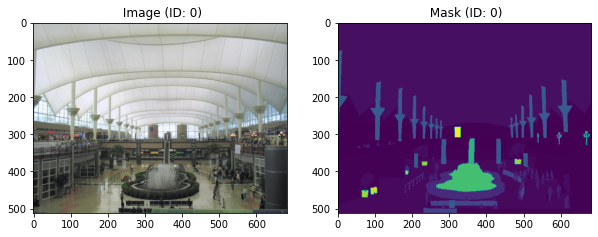

In [6]:
display(train_img_dir, train_seg_dir)

In [7]:
train_ds = tf.data.Dataset.list_files(train_img_dir + '\\*.jpg', seed = SEED)
val_ds = tf.data.Dataset.list_files(val_img_dir + "\\*.jpg", seed = SEED)

In [8]:
def decode_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 1)
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)

    return {'image': img, 'mask': mask}

In [9]:
train_ds = train_ds.map(decode_img)
val_ds = val_ds.map(decode_img)

## Data Preprocessing

In [10]:
@tf.function
def load_image(datapoint):
    input_img = tf.image.resize(datapoint['image'], (WIDTH, HEIGHT))
    input_mask = tf.image.resize(datapoint['mask'], (WIDTH, HEIGHT))
    
    if tf.random.uniform(()) > 0.5:
        input_img = tf.image.flip_left_right(input_img)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_img = tf.cast(input_img, tf.float32) / 255.0
    
    return input_img, input_mask

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(load_image, num_parallel_calls = AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size = BUFFER_SIZE, seed=SEED).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.repeat().batch(batch_size = BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)

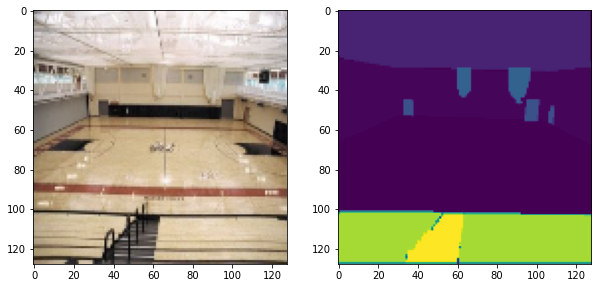

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(1):
        plt.subplot(1,2,1)
        img = images[i].numpy() * 255
        plt.imshow(img.astype('uint8'))
        plt.subplot(1,2,2)
        plt.imshow(keras.preprocessing.image.array_to_img(labels[i]))

## Model Building

In [13]:
initializer = 'he_normal'

In [14]:
def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same', initializer=initializer):
    return Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(inputs)

In [15]:
def encoder(x, init_filter_num=32, depth=4, pool_size=(2,2), initializer=initializer):
    levels = []
    for d in range(depth):
        for i in range(2):
            x = conv_block(x, init_filter_num * (2**d * 2), initializer=initializer)
        levels.append(x)
        x = MaxPooling2D(pool_size=pool_size)(x)
    return x, levels

In [16]:
def decoder(x, levels, init_filter_num=32, depth=4, kernel_size=2, 
            pool_size=(2,2), strides=(2,2), initializer=initializer):
    for d in reversed(range(depth)):
        x = Conv2DTranspose(filters=init_filter_num * 2**d * 2, kernel_size=kernel_size, strides=strides)(x)
        x = concatenate([x, levels[d]], axis=-1)
        for i in range(2):
            x = conv_block(x, init_filter_num * 2**d * 2, initializer=initializer)
    return x

In [17]:
def UNet(input_shape=(HEIGHT, WIDTH, 3), n_classes=N, depth=4, init_filter_num=32,
         out_activation='sigmoid', initializer=initializer):
    inputs = Input(input_shape)
    
    x, levels = encoder(inputs, init_filter_num=init_filter_num, depth=depth, initializer=initializer)
    
    for i in range(2):
        x = conv_block(x, init_filter_num * 2**depth * 2)
        
    x = decoder(x, levels, init_filter_num=init_filter_num, depth=depth, initializer=initializer)
    
    out = conv_block(x, n_classes, kernel_size=1, activation=out_activation, padding='valid')
    model = keras.Model(inputs=inputs, outputs=out)
    
    return model

In [18]:
model = UNet()

In [19]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    
    return pred_mask

In [21]:
def show_pred(dataset = None, num = 1):
    if dataset:
        for img, mask in dataset.take(num):
            pred_mask = model.predict(img)
            display_sample([img[0], mask[0], create_mask(pred_mask)[0]])
    else:
        one_img_batch = sample_image[0][tf.newaxis, ...]
        inference = model.predict(one_img_batch)
        pred_mask = create_mask(inference)
        display_sample([sample_image[0], sample_mask[0], pred_mask[0]])	

In [22]:
def display_sample(display_list):
    plt.figure(figsize=(18, 18))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),'gray')
        plt.axis('off')
    plt.show()	

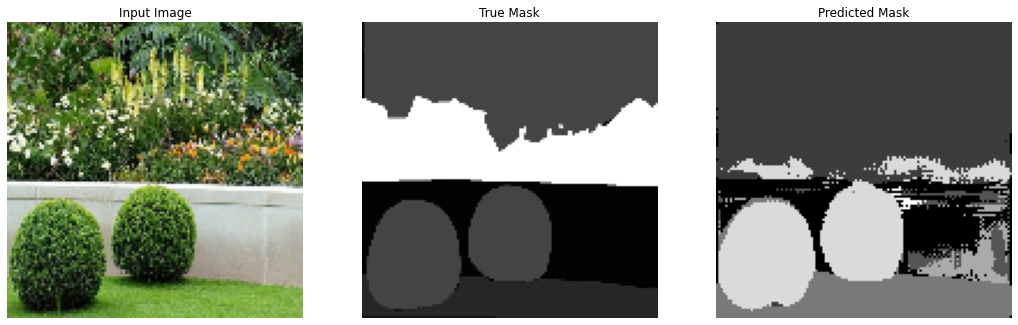

In [131]:
for image, mask in train_ds.take(1):
    sample_image, sample_mask = image, mask

show_predictions(train_ds)

## Training

In [23]:
EPOCHS = 1

STEPS_PER_EPOCH = train_size // BATCH_SIZE
VALIDATION_STEPS = val_size // BATCH_SIZE

In [25]:
model_history = model.fit(train_ds, epochs = EPOCHS,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          validation_steps = VALIDATION_STEPS,
                          validation_data = val_ds)

5052/5052 [==============================] - 2463s 486ms/step - loss: 2.0233 - accuracy: 0.5053 - val_loss: 2.0014 - val_accuracy: 0.5045


In [47]:
model_history = model.fit(train_ds, epochs = EPOCHS,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          validation_steps = VALIDATION_STEPS,
                          validation_data = val_ds)

5052/5052 [==============================] - 3993s 784ms/step - loss: 1.9482 - accuracy: 0.5197 - val_loss: 1.9475 - val_accuracy: 0.5194


In [49]:
model.save_weights('trained_01.hdf5')

## Evaluation

In [23]:
model.load_weights('trained_01.hdf5')

In [24]:
model.evaluate(val_ds, steps=50)

50/50 [==============================] - 12s 97ms/step - loss: 1.8091 - accuracy: 0.5578


[1.8652355670928955, 0.539868175983429]

In [25]:
def evaluation_metrics(pred, label, class_num):
    class_pred = np.asarray(pred[...,class_num])
    class_label = np.asarray(label[...,class_num])

    P = np.sum(class_label == class_pred)
    F = np.sum(class_label != class_pred)

    print('P:{},\t F:{}'.format(P, F))
    print('ACC = {:.4}%'.format(P/F * 100))

In [26]:
def get_pred(model, ds, idx=0):
    for image, mask in ds.take(1):
        pred_mask = model.predict(image)
        pred = create_mask(pred_mask)[idx]
        
        plt.subplot(1,2,1)
        plt.imshow(mask[0,...,0])
        plt.title('GT')
        plt.subplot(1,2,2)
        plt.imshow(pred[...,0])
        plt.title('Pred')
        plt.axis('off')
        
        evaluation_metrics(pred, mask, 0)

25869
P:25869,	 F:39667
ACC = 65.22%


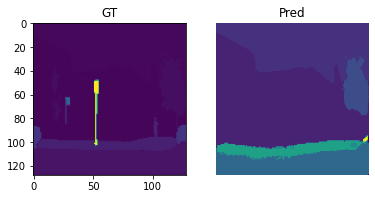

In [120]:
get_pred(model, val_ds)